In [1]:
import pandas as pd
import os
import scipy.io as sio
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import numpy as np
import pandas as pd
from ase import neighborlist
from ase.build import molecule
from scipy import sparse
from ase import Atoms
from scipy import sparse
import ase.io as aio

In [2]:
DATA_DIR = "/home/pranav/vasp_out/ice_cub_block/matfiles"
POSCAR_DIR = "/home/pranav/jobs/ice_cub_block"

In [3]:
def extractBlockNum(filename):
    n = list(map(int, re.findall(r'\d+', filename)))
    return n[0]

In [4]:
def loadMatrices():
    orbMats = {}
    distMats = {}
    bondMats = {}
    posMats = {}
    for subdir, dirs, files in os.walk(DATA_DIR):
        for file in files:
            filepath = subdir + os.sep + file
            idx = extractBlockNum(file)
            # print(file)
            # print(idx)
            if "orbitals" in filepath:
                orbMat = pd.DataFrame(sio.loadmat(filepath)['OrbMat'])
                orbMats[idx] = orbMat
            elif "distances" in filepath:
                distMat = pd.DataFrame(sio.loadmat(filepath)['AtomDist'])
                distMats[idx] = distMat
            elif "bondmatrix" in filepath:
                bondMat = pd.DataFrame(sio.loadmat(filepath)['BondMat'])
                bondMats[idx] = bondMat
            elif "locations" in filepath:
                posMat = pd.DataFrame(sio.loadmat(filepath)['locMat'])
                posMats[idx] = posMat
    return [orbMats, distMats, bondMats, posMats]

In [5]:
orbMats, distMats, bondMats, posMats = loadMatrices()

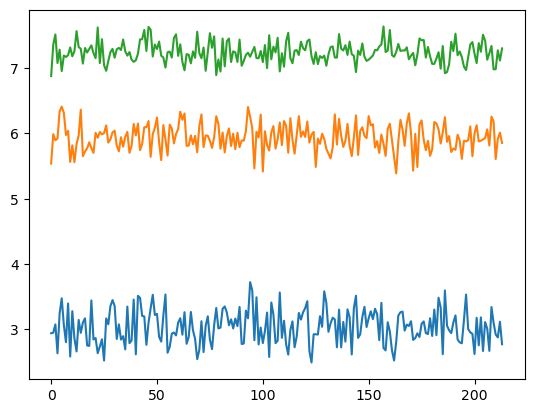

In [6]:
y = [posMats[key].loc[0, :] for key in posMats]
x = np.arange(len(posMats))
plt.plot(x, y)

In [7]:
NUM_BLOCKS = len(orbMats)

In [8]:
INF = 10000
JOB_NAME = "ice_cub_block"
OXY_FIRST = False
SAVE_DIR = "ice_cub_block_dataset"
SAVE_DATASET = False
PBC = [1, 1, 1]
CELL = [13.506, 15.596, 14.656]

In [9]:
NUM_ATOMS = int(distMats[1].shape[0])
NUM_WATER = NUM_ATOMS // 3
if(OXY_FIRST):
    FIRST_WATER_IDX = 0
    LAST_WATER_IDX = NUM_WATER - 1
else:
    FIRST_WATER_IDX = NUM_ATOMS - NUM_WATER
    LAST_WATER_IDX = NUM_ATOMS - 1
print("NUM_WATER: ", NUM_WATER)
print("FIRST W INDEX: ", FIRST_WATER_IDX)

symbols =  (['O' for i in range(NUM_WATER)] + ['H' for i in range(NUM_WATER * 2)]) if OXY_FIRST else (['H' for i in range(NUM_WATER * 2)] + ['O' for i in range(NUM_WATER)])

NUM_WATER:  96
FIRST W INDEX:  192


In [10]:
init_atoms = aio.read(f"{POSCAR_DIR}/POSCAR", format='vasp')
print(init_atoms)
nat_cutoffs = np.array(neighborlist.natural_cutoffs(init_atoms)) * 1.5
print(nat_cutoffs)
nl = neighborlist.NeighborList(nat_cutoffs, self_interaction=False, bothways=True)
nl.update(init_atoms)
adj = nl.get_connectivity_matrix()
adj_list = adj.toarray()
sums = np.sum(adj_list, axis=1)
if(OXY_FIRST):
    print(sums[:LAST_WATER_IDX+1])
    print(sums[LAST_WATER_IDX+1:])
else:
    print(sums[:FIRST_WATER_IDX])
    print(sums[FIRST_WATER_IDX:])

Atoms(symbols='H192O96', pbc=True, cell=[13.506, 15.596, 14.656])
[0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465
 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.465 0.4

In [11]:
def is_oxygen(idx):
    '''Check atom given by index is an oxygen atom'''
    return (FIRST_WATER_IDX <= idx <= LAST_WATER_IDX)

def sort_last(l):
    '''Sorts a list l from index 2 to end'''
    l[2:] = sorted(l[2:])
    return l


def build_input(idx, distanceMatrix):
    '''
    Sorts the array created by traverse() by every 5th element and sorts the last 3 elements in each group of 5.
    '''
    res = np.array(traverse(idx, -1, distanceMatrix, [], 0)).reshape(4,5)
    # print(res)
    res = np.array(sorted(res, key=lambda row: row[0]))
    # print(res)
    res = np.array(list(map(sort_last, res)))
    # print(res)
    # print(res.flatten())
    return res.flatten()

def traverse(cur, parent, distanceMatrix, res=[], deg=0):
    '''
    DFS an adjacency matrix that describes an atomic structure and build the
    length 20 array that can describe the atomic structure around the starting particle.
    This length 20 array is used as input for the neural network.
    '''
    # dont traverse more than 3 connections away from start
    if deg > 3: 
        return
    
    added = 0
    if (parent != -1):
        dist = distanceMatrix[cur][parent]
        res.append(dist)
        added += 1
    for i in range(NUM_WATER * 3):
        if adj_list[cur][i] and i != parent:
            added += 1
            traverse(i, cur, distanceMatrix, res, deg+1)

    # fill deg 1 hydrogens with nulls if are in one of the root indices
    if(deg == 1 and added == 1):
        res += ([INF] * 4)

    # fill nulls
    while(added < 4 and is_oxygen(cur)):
        if(deg > 0): res.append(INF)
        else:
            res += ([INF] * 5)
        added +=1
    if len(res) == 20: return res
    # print(res)
    # print(len(res))


def build_dataset(distanceMatrix, orbitalMatrix):
    '''
    Call build_input for all oxygen atom, combine this with the s integral for each oxygen atom to create the dataset
    '''
    dataset_array = []
    for i in range(FIRST_WATER_IDX, LAST_WATER_IDX + 1):
        # print(i)
        x = build_input(i, distanceMatrix)
        orbIdx = FIRST_WATER_IDX + ( (i - FIRST_WATER_IDX) * 4 )
        y = orbitalMatrix[orbIdx][orbIdx]
        dataset_row = np.append(x, y)
        dataset_array.append(dataset_row)

    return pd.DataFrame(dataset_array)

In [12]:
col_names = ["" for i in range(21)]
col_names[20] = "S-integral"
for i in range(20):
    if (i % 5 == 0): col_names[i] = f"C{i//5}"
    elif (i % 5 == 1): col_names[i] = f"B{i//5}"
    else: col_names[i] = f"L{i // 5}_{(i % 5) - 1}"

In [13]:
all_datasets = []
for i in range(1, NUM_BLOCKS+1):
    # i = 200
    # print(i)
    distMat = distMats[i]
    orbMat = orbMats[i]
    # print(posMat)
    dataset = build_dataset(distMat, orbMat)
    dataset.columns = col_names
    all_datasets.append(dataset)

In [14]:
len(all_datasets)

214

In [15]:
master_dataset = pd.concat(all_datasets, ignore_index=True)

In [16]:
master_dataset.shape

(20544, 21)

In [17]:
master_dataset

,C0,B0,L0_1,L0_2,L0_3,C1,B1,L1_1,L1_2,L1_3,...,B2,L2_1,L2_2,L2_3,C3,B3,L3_1,L3_2,L3_3,S-integral
0,0.979261,1.618141,0.983214,1.011566,1.739166,1.056929,1.940873,0.996113,1.002606,1.673609,...,1.024210,1.035154,1.712423,1.857599,1.994728,0.986468,0.963554,1.617049,1.927436,-20.251655
1,0.916680,1.685511,1.003966,1.005907,1.833427,1.011820,1.594906,1.040008,1.050460,2.030146,...,0.983214,1.011566,1.618141,1.739166,1.814020,1.028515,1.048402,1.731255,1.845230,-20.995382
2,0.939945,1.673609,0.996113,1.002606,1.940873,1.023201,1.774027,0.982671,1.001479,1.720130,...,0.986993,0.998493,1.742922,1.830239,1.842439,1.040008,1.050460,1.594906,2.030146,-21.253033
3,0.949274,1.580471,1.006289,1.007837,1.930799,1.034273,1.826111,0.969066,0.997273,1.889906,...,1.019325,1.014644,1.764946,1.775375,1.856382,0.996113,1.002606,1.673609,1.940873,-20.559805
4,0.969066,1.612425,0.929527,1.029291,1.877435,0.997273,1.893689,0.954752,1.023086,1.902538,...,1.034273,0.949274,1.611584,1.856382,1.889906,0.927566,1.028822,1.485667,1.603122,-20.833009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20539,0.992128,1.788552,0.984071,1.007439,1.870200,1.017163,1.707009,1.019434,1.053110,1.782090,...,0.968668,0.984715,1.719198,1.755522,1.896964,0.971194,1.004885,1.676530,1.681851,-20.579974
20540,1.019434,1.689866,0.938273,1.052223,1.786264,1.053110,1.685641,1.013320,1.016895,1.930521,...,1.017163,0.992128,1.770686,1.896964,1.782090,1.034827,0.983528,1.787396,2.026481,-20.507654
20541,1.010274,2.050928,0.972604,1.029597,1.468544,1.070442,1.670460,0.976442,1.051688,1.743443,...,1.027450,0.990752,1.625772,1.868849,1.734422,1.013320,1.016895,1.685641,1.930521,-20.872226
20542,0.958125,1.836311,1.008226,1.024254,2.017499,1.001036,1.625772,0.990752,1.027450,1.868849,...,1.006024,1.080994,1.719751,1.910661,1.953523,1.041880,1.005815,1.828779,1.892945,-20.672962


In [71]:
master_dataset.to_csv("Ice_Cub_Block.csv", index=False)